In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.options import Options  


In [2]:
datetime.now()

datetime.datetime(2020, 2, 12, 0, 12, 8, 163543)

In [3]:
chrome_options = Options()  
chrome_options.add_argument("--headless")  
chrome_options.add_argument("--no-sandbox")

driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [4]:
url = 'https://ncov.dxy.cn/ncovh5/view/pneumonia'
driver.get(url)

### Extract date

In [5]:
content = driver.page_source
soup =BeautifulSoup(content, 'lxml')


In [6]:
data = soup.findAll(text=re.compile("截至 .+"))
data

['try { window.getIndexRumorList = [{"id":142,"title":"保持喉咙湿润可以预防病毒？","mainSummary":"剑桥大学病毒学助理研究员韩越：没有研究显示频繁喝水能预防新冠病毒感染","summary":"","body":"有传言称「即便吸入了病毒，如果喉咙湿润的话，病毒大多会沿食道进入胃部，而不是沿呼吸道进入肺部。胃里有胃酸，能有效杀死病毒，所以要多喝水」其实新冠病毒通过侵染呼吸道黏膜上皮细胞，并在细胞中大量增殖完成侵染，多喝水并不能阻止细胞进入呼吸道。胃酸虽可杀死病毒，但不是全部病毒，新冠病毒存在侵染胃部细胞的可能性。水喝太多可能使体内电解质失衡，对肾脏等器官造成额外负担！","sourceUrl":"","score":141,"rumorType":0},{"id":141,"title":"深呼吸再憋十秒可测是否有肺炎？","mainSummary":"丁香医生团队辟谣：真没必要用这样的方式去检查有没有肺炎","summary":"","body":"有肺炎的话，你会咳嗽、呼吸急促，甚至喘不过气，很容易就能认得出，必要时还有 CT 识别手段。就算毫无肺炎表现，只要有发热以及相关密切接触史，也得尽快就医，并不是没有肺炎就安全。假如你一切良好，看到这则谣言不由自主做几次深吸气检查也没关系，会稍稍刺激迷走神经，还可能让气道高敏的人忍不住咳几声，这并不会有明显危害，记得别连续深吸气「复查」就行了。","sourceUrl":"","score":140,"rumorType":0},{"id":139,"title":"钟南山：新冠肺炎治愈后会有后遗症？","mainSummary":"丁香医生团队查证：钟南山院士没有说过此话","summary":"","body":"经查证，钟南山院士并没有说过此话。相反，1 月 31 日，钟南山院士在接受北京卫视《养生堂》采访时提到：到现在我没有发现有很明显的后遗症，治愈的可能以后会大量增加。","sourceUrl":"","score":139,"rumorType":0},{"id":136,"title":"新冠病毒属于SARS病毒？","mainSummary":"华中农业大学教授陈焕春解释：完全属于口误","summary":"","body":"9 日

In [7]:
for s in data:
    m = re.search("截至 (202\d-\d+-\d+ \d+:\d+)", s)
    if m is not None:
        data_date_time = m.group(1)
data_date_time

'2020-02-12 00:06'

### Extract data (summary)

In [8]:
data = soup.findAll(text=re.compile('\"summary.+\"confirmedCount\":\d'))

data


['try { window.getStatisticsService = {"id":1,"createTime":1579537899000,"modifyTime":1581466002000,"infectSource":"该字段已替换为说明2","passWay":"该字段已替换为说明3","imgUrl":"https://img1.dxycdn.com/2020/0201/450/3394153392393266839-135.png","dailyPic":"https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png,https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png,https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png,https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png,https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png,https://img1.dxycdn.com/2020/0211/089/3395998939840182072-135.png","dailyPics":["https://img1.dxycdn.com/2020/0211/763/3395998884005602079-135.png","https://img1.dxycdn.com/2020/0211/362/3395998896890788910-135.png","https://img1.dxycdn.com/2020/0211/365/3395998905480724211-135.png","https://img1.dxycdn.com/2020/0211/364/3395998916217859778-135.png","https://img1.dxycdn.com/2020/0211/922/3395998929103046444-135.png","https://i

In [9]:
m = re.search('\"confirmedCount\":(\d+)', data[0])
summary_confirmed_count = int(m.group(1))


m = re.search('\"curedCount\":(\d+)', data[0])
summary_cured_count = int(m.group(1))

m = re.search('\"deadCount\":(\d+)', data[0])
summary_dead_count = int(m.group(1))


In [10]:
# make a dataframe
df = pd.DataFrame({
    'datetime': data_date_time,
    'confirmed': summary_confirmed_count,
    'cured': summary_cured_count,
    'dead': summary_dead_count
}, index=[0])
df

,datetime,confirmed,cured,dead
0,2020-02-12 00:06,44437,4638,1112


### Save to file

In [11]:
from pathlib import Path
csv_file = 'data/china-summary-cases.csv'

if Path(csv_file).exists():
    # read out the old data - then merge with new data and remove duplicates based on datetime
    old_df = pd.read_csv(csv_file)
    df = df.append(old_df)
df.drop_duplicates(subset=['datetime'], inplace=True)

In [12]:
df.sort_values(by=['datetime'], inplace=True)

df.to_csv(csv_file, index=False)


### Plot graph

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

png_file = 'images/china-summary-cases.png'
# convert to pd.datetime
df['datetime_idx'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")

df.set_index('datetime_idx', inplace=True)
df.drop(['datetime'], axis=1, inplace=True)


In [14]:
df

,confirmed,cured,dead
datetime_idx,,,
2020-02-02 10:22:00,14483,379,304
2020-02-02 10:28:00,14483,380,304
2020-02-02 11:19:00,14489,385,304
2020-02-02 11:54:00,14489,397,304
2020-02-02 15:01:00,14490,430,304
...,...,...,...
2020-02-11 12:23:00,42744,4255,1017
2020-02-11 14:01:00,42744,4299,1017
2020-02-11 14:25:00,42747,4299,1017


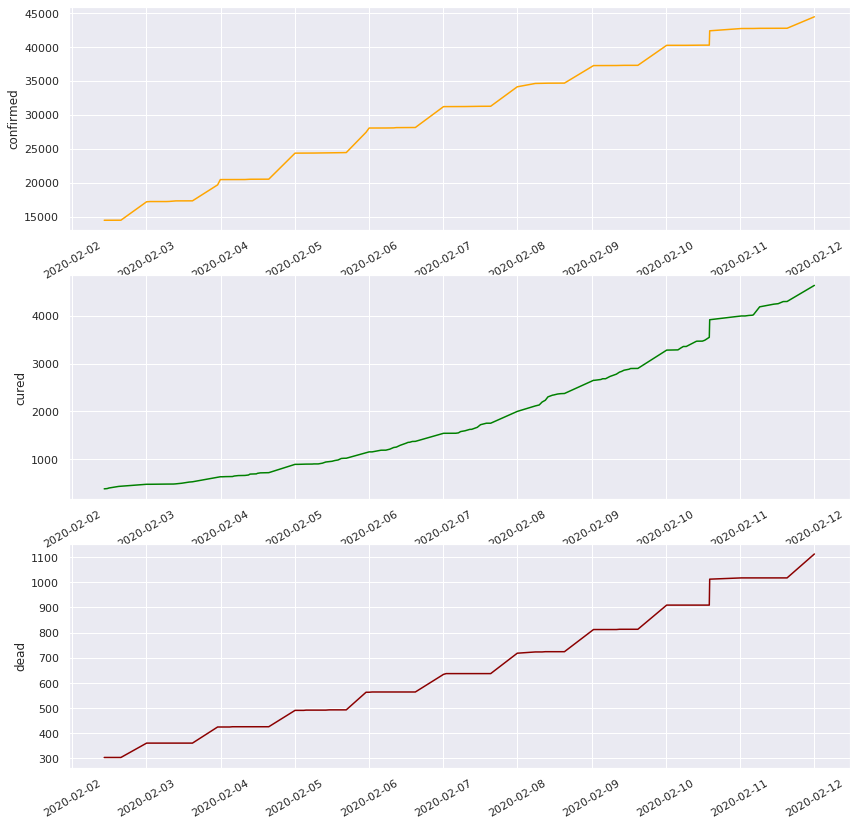

In [15]:
if df.shape[0]>1:
    # line chart when having at least a few points
    sns.set(rc={'figure.figsize':(14,14)})

    fig, axs = plt.subplots(nrows=3)

    sns.lineplot(x=df.index, y = 'confirmed', data=df, ax= axs[0], estimator=None, color='orange')
    sns.lineplot(x=df.index, y = 'cured', data=df, ax= axs[1], estimator=None, color='green')
    sns.lineplot(x=df.index, y = 'dead', data=df, ax= axs[2], estimator=None, color='darkred')

    for ax in axs:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelrotation=30)
else:

    ax = df.plot(kind='bar', stacked=True, figsize=(9,6))
    fig = ax.get_figure()
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(0) 


In [16]:
fig.savefig(png_file)